In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import ast
from networkx.utils import py_random_state
import math
import time

%matplotlib inline

In [2]:
def plot_degree_dist(G):
    
    degrees = [G.degree(n) for n in G.nodes()]
    kmin = min(degrees)
    kmax = max(degrees)
    
    if kmin>0:
        bin_edges = np.logspace(np.log10(kmin), np.log10(kmax)+1, num=20)
    else:
        bin_edges = np.logspace(0, np.log10(kmax)+1, num=20)
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)

    fig = plt.figure(figsize=(6,4))

    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)
    plt.loglog(x, density, marker='o', linestyle='none')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [3]:
df = pd.read_csv('Seasons_Stats.csv')
display(df)

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27435,27435,2022.0,Markieff Morris,NaN,32.0,MIA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27436,27436,2022.0,Markelle Fultz,NaN,24.0,ORL,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27437,27437,2022.0,Marcus Smart,NaN,28.0,BOS,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27438,27438,2022.0,Marcus Garrett,NaN,23.0,MIA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
G = nx.Graph()

In [5]:
added_player = []
players = []
for x in range(len(df)):
    if df.loc[x]['Tm'] not in ['TOT']:
        player =  df.loc[x]["Player"]
        team =  df.loc[x]["Tm"]
        year = df.loc[x]["Year"]
        idv_player = []
        idv_player.append(player)
        idv_player.append(team)
        idv_player.append(year)
        players.append(idv_player)
    if player not in added_player:
        G.add_node(player, type='player', year=year, color='green')
        added_player.append(player)
    else: 
        (G.nodes[player]['year']) = year
             
for player1 in players:
    for player2 in players:
        if player1[1] == player2[1] and player1[2] == player2[2]:
            G.add_edge(player1[0], player2[0], team=player2[1], year=int(player2[2]))


In [6]:
# print(G.nodes)
print(G.number_of_nodes())
print(G.number_of_edges())
nx.write_graphml(G,'nbadestemp.graphml')

4511
143625


In [7]:
def double_edge_swap(G, nswap=1, max_tries=100, seed=None):
    if G.is_directed():
        raise nx.NetworkXError("double_edge_swap() not defined for directed graphs.")
    if nswap > max_tries:
        raise nx.NetworkXError("Number of swaps > number of tries allowed.")
    if len(G) < 4:
        raise nx.NetworkXError("Graph has less than four nodes.")
    # Instead of choosing uniformly at random from a generated edge list,
    # this algorithm chooses nonuniformly from the set of nodes with
    # probability weighted by degree.
    n = 0
    swapcount = 0
    keys, degrees = zip(*G.degree())  # keys, degree
    cdf = nx.utils.cumulative_distribution(degrees)  # cdf of degree
    discrete_sequence = nx.utils.discrete_sequence

    while swapcount < nswap:
        #        if random.random() < 0.5: continue # trick to avoid periodicities?
        # pick two random edges without creating edge list
        # choose source node indices from discrete distribution
        (ui, xi) = discrete_sequence(2, cdistribution=cdf, seed=seed)
        if ui == xi:
            continue  # same source, skip
        u = keys[ui]  # convert index to label
        x = keys[xi]
        if (abs(G.nodes[u]['year'] - G.nodes[x]['year']) > 22):
            continue
        # choose target uniformly from neighbors
        v = random.choice(list(G[u]))
        y = random.choice(list(G[x]))
        if v == y:
            continue  # same target, skip
        if (abs(G.nodes[v]['year'] - G.nodes[y]['year']) > 22):
            continue # too far apart in time, skip
        if (x not in G[u]) and (y not in G[v]):  # don't create parallel edges
            G.add_edge(u, x)
            G.add_edge(v, y)
            G.remove_edge(u, v)
            G.remove_edge(x, y)
            swapcount += 1
        if n >= max_tries:
            e = (
                f"Maximum number of swap attempts ({n}) exceeded "
                f"before desired swaps achieved ({nswap})."
            )
            raise nx.NetworkXAlgorithmError(e)
        n += 1
    return G

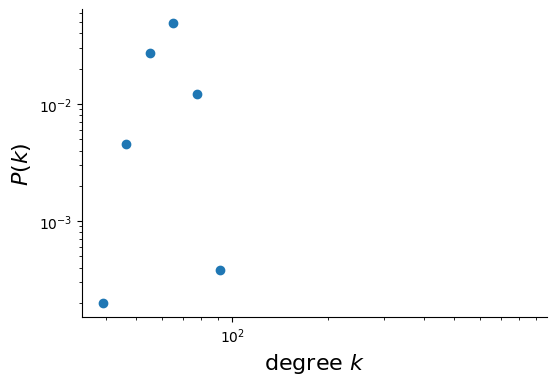

In [8]:
GN = len(G.nodes())
max_L = GN*(GN-1)/2
actual_L = len(G.edges())
p = actual_L/max_L

ER = nx.erdos_renyi_graph(GN, p, directed=False)

plot_degree_dist(ER)

In [9]:
# This is just one instance of a random graph. We need to create an ensemble.

clustering_ER = []

for i in range(1000): # 1000 is better
    
    ER = nx.erdos_renyi_graph(GN, p, directed=False)
    C_ER = np.mean(list(nx.clustering(ER).values()))
    clustering_ER.append(C_ER)


print(np.mean(clustering_ER))
print(np.std(clustering_ER))


0.01411957155336027
7.788642418047858e-05


In [10]:
# Let's create the ensemble.

clustering_DP = []

for i in range(1000): # 1000 is better
    
    double_edge_swap(G,nswap=10*G.number_of_edges(),max_tries=10000000)
    C_DP = np.mean(list(nx.clustering(G).values()))
    clustering_DP.append(C_DP)

    
print(np.mean(clustering_DP))
print(np.std(clustering_DP))